In [129]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 

In [130]:
#upload data
df1 = pd.read_csv('rdfn_wa_county_updated_.csv') #RedFin
df2 = pd.read_csv('4_regimes_monthly_updated_.csv') #FRED

### Define models: Linear Regression, Lasso, Ridge, ElasticNet

In [131]:
def model_lin_reg(lookback, lookforward, df1):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error

    features = []
    for i in df1.keys():
        if i not in ['Region', 'Month of Period End']: #don't need these two columns
            features.append(i)

    df1 = df1[features].reset_index(drop=True)
    #function to split X into feature matrix
    def ts_split(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
        return X
    # Forecasting target t+n days ahead **Not Utilized**
    def ts_split_y_n(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps + target_steps - 1]
                    for idx in range(n_obs)])
        return y
    # Forecasting target t+1 ahead
    def ts_split_y_1(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                    for idx in range(n_obs)])
        return y

    value_features = lookback #we use last 24 months
    value_target = lookforward #to forecast 1 month median sale price
    #split the data into features 

    df1_features_dict = {}  # Dictionary to hold the dynamically created variables
    for feature in features:
        feature_name = f"df1_{feature}"  # Dynamically create a variable name
        df1_features_dict[feature_name] = ts_split(np.array(df1[feature]), feature_steps=value_features, target_steps=value_target)

    #Target var of predicting price t+1 month ahead
    y_coin = ts_split_y_1(np.array(df1['Median Sale Price']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    #combined_array = np.stack((coin_open, coin_high , coin_low, coin_close, coin_vol), axis=1)
    combined_array = np.stack(list(df1_features_dict.values()), axis=1)
    X = combined_array

    # Determine the size of the training set
    train_idx = round(len(X)*0.5) # we use 50% of data sent from (1/12 - 7/23) 
    X_train_full= X[:train_idx] ## all same for each model

    #test data for X and y targets
    X_test= X[train_idx:]
    y_test_coin = y_coin[train_idx:]

    val_idx = round(train_idx * 0.1)  #last 10% of the training set (because time-series)
    train_idx_final = train_idx - val_idx

    #Split the training data into training and validation sets
    X_train = X_train_full[:train_idx_final]
    X_val = X_train_full[train_idx_final:train_idx]

    #train and validation for target variable
    y_train_coin = y_coin[:train_idx_final]
    y_val_coin = y_coin[train_idx_final:train_idx]

    #reshape and convert all into pandas series
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_train_reshaped = pd.DataFrame(X_train_reshaped)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
    X_val_reshaped = pd.DataFrame(X_val_reshaped)

    y_train_coin = pd.DataFrame(y_train_coin)
    y_val_coin = pd.DataFrame(y_val_coin)

    #reshape test
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    X_test_reshaped = pd.DataFrame(X_test_reshaped)

    y_test_coin_reshaped = y_test_coin.reshape(y_test_coin.shape[0], -1)
    y_test_coin_reshaped = pd.DataFrame(y_test_coin_reshaped)

    # Initialize the StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Create and train the Linear Regression model
    linear_reg = LinearRegression()
    model_lr = linear_reg.fit(X_train_scaled, y_train_coin.values.ravel()) #not utilizing val so really trained on 40% data (1/12 to 7/23)

    # Predict on the validation and test sets
    #y_val_pred = model_lr.predict(X_val_scaled)
    #y_test_pred_lr = model_lr.predict(X_test_scaled)

    return model_lr, X, scaler #return the model itself, full X feature matrix, and associated scaler used


In [132]:
def model_lasso_reg(lookback, lookforward, df1):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_squared_error

    features = []
    for i in df1.keys():
        if i not in ['Region', 'Month of Period End']:
            features.append(i)
    #df1 = history[['open', 'high', 'low', 'close', 'volume']].reset_index(drop=True)
    df1 = df1[features].reset_index(drop=True)

    #function to split X into feature matrix
    def ts_split(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
        return X
    # Forecasting target t+n days ahead **Not Utilized**
    def ts_split_y_n(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps + target_steps - 1]
                    for idx in range(n_obs)])
        return y
    # Forecasting target t+1 ahead
    def ts_split_y_1(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                    for idx in range(n_obs)])
        return y

    value_features = lookback #we use last 24 months
    value_target = lookforward #to forecast 1 month median sale price
    #split the data into features 

    df1_features_dict = {}  # Dictionary to hold the dynamically created variables
    for feature in features:
        feature_name = f"df1_{feature}"  # Dynamically create a variable name
        df1_features_dict[feature_name] = ts_split(np.array(df1[feature]), feature_steps=value_features, target_steps=value_target)


    #Target var of predicting price t+1 month ahead
    y_coin = ts_split_y_1(np.array(df1['Median Sale Price']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    #combined_array = np.stack((coin_open, coin_high , coin_low, coin_close, coin_vol), axis=1)
    combined_array = np.stack(list(df1_features_dict.values()), axis=1)
    X = combined_array

    # Determine the size of the training set
    train_idx = round(len(X)*0.5) # we use 50% of data sent from (1/12 - 7/23) 
    X_train_full= X[:train_idx] ## all same for each model

    #test data for X and y targets
    X_test= X[train_idx:]
    y_test_coin = y_coin[train_idx:]

    val_idx = round(train_idx * 0.1)  #last 10% of the training set (because time-series)
    train_idx_final = train_idx - val_idx

    #Split the training data into training and validation sets
    X_train = X_train_full[:train_idx_final]
    X_val = X_train_full[train_idx_final:train_idx]

    #train and validation for targets
    y_train_coin = y_coin[:train_idx_final]
    y_val_coin = y_coin[train_idx_final:train_idx]

    #reshape and convert all into pandas series
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_train_reshaped = pd.DataFrame(X_train_reshaped)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
    X_val_reshaped = pd.DataFrame(X_val_reshaped)

    y_train_coin = pd.DataFrame(y_train_coin)
    y_val_coin = pd.DataFrame(y_val_coin)

    #reshape test
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    X_test_reshaped = pd.DataFrame(X_test_reshaped)

    y_test_coin_reshaped = y_test_coin.reshape(y_test_coin.shape[0], -1)
    y_test_coin_reshaped = pd.DataFrame(y_test_coin_reshaped)

    # Initialize the StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Create and train the Linear Regression model
    lasso_reg = Lasso(alpha=10.0) #optimized via grid search
    model_lasso = lasso_reg.fit(X_train_scaled, y_train_coin.values.ravel()) #not utilizing val so really trained on 40% data (1/12 to 7/23)

    # Predict on the validation and test sets
    #y_val_pred = model_lasso.predict(X_val_scaled)
    #y_test_pred_lasso = model_lasso.predict(X_test_scaled)

    return model_lasso, X, scaler #return the model itself, full X feature matrix, and associated scaler used


In [133]:
def model_ridge_reg(lookback, lookforward, df1):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge
    from sklearn.metrics import mean_squared_error

    features = []
    for i in df1.keys():
        if i not in ['Region', 'Month of Period End']:
            features.append(i)
    df1 = df1[features].reset_index(drop=True)

    #function to split X
    def ts_split(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
        return X
    # Forecasting target t+n days ahead
    def ts_split_y_n(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps + target_steps - 1]
                    for idx in range(n_obs)])
        return y
    # Forecasting target t+1 ahead
    def ts_split_y_1(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                    for idx in range(n_obs)])
        return y

    value_features = lookback #we use last 24 months
    value_target = lookforward #to forecast 1 month median sale price
    #split the data into features with correct format

    df1_features_dict = {}  # Dictionary to hold the dynamically created variables
    for feature in features:
        feature_name = f"df1_{feature}"  # Dynamically create a variable name
        df1_features_dict[feature_name] = ts_split(np.array(df1[feature]), feature_steps=value_features, target_steps=value_target)

    #Target var of predicting price t+1 month ahead
    y_coin = ts_split_y_1(np.array(df1['Median Sale Price']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    #combined_array = np.stack((coin_open, coin_high , coin_low, coin_close, coin_vol), axis=1)
    combined_array = np.stack(list(df1_features_dict.values()), axis=1)
    X = combined_array

    # Determine the size of the validation set
    train_idx = round(len(X)*0.5)
    X_train_full= X[:train_idx] ## all same for each model

    #test data for X and y targets
    X_test= X[train_idx:]
    y_test_coin = y_coin[train_idx:]

    val_idx = round(train_idx * 0.1)  # 10% of the training set
    train_idx_final = train_idx - val_idx

    # Split the training data into training and validation sets
    X_train = X_train_full[:train_idx_final]
    X_val = X_train_full[train_idx_final:train_idx]

    #train and validation for targets
    y_train_coin = y_coin[:train_idx_final]
    y_val_coin = y_coin[train_idx_final:train_idx]

    #reshape and convert all into pandas series
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_train_reshaped = pd.DataFrame(X_train_reshaped)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
    X_val_reshaped = pd.DataFrame(X_val_reshaped)

    y_train_coin = pd.DataFrame(y_train_coin)
    y_val_coin = pd.DataFrame(y_val_coin)

    #reshape test
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    X_test_reshaped = pd.DataFrame(X_test_reshaped)

    y_test_coin_reshaped = y_test_coin.reshape(y_test_coin.shape[0], -1)
    y_test_coin_reshaped = pd.DataFrame(y_test_coin_reshaped)

    # Initialize the StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Create and train the Linear Regression model
    ridge_reg = Ridge(alpha=0.01) #optimized via grid search
    model_ridge = ridge_reg.fit(X_train_scaled, y_train_coin.values.ravel())

    return model_ridge, X, scaler #return the model itself, full X feature matrix, and associated scaler used


In [134]:
def model_en_reg(lookback, lookforward, df1):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import ElasticNet

    features = []
    for i in df1.keys():
        if i not in ['Region', 'Month of Period End']:
            features.append(i)

    df1 = df1[features].reset_index(drop=True)

    #function to split X
    def ts_split(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
        return X
    # Forecasting target t+n days ahead
    def ts_split_y_n(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps + target_steps - 1]
                    for idx in range(n_obs)])
        return y
    # Forecasting target t+1 ahead
    def ts_split_y_1(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                    for idx in range(n_obs)])
        return y

    value_features = lookback #we use last 24 months
    value_target = lookforward #to forecast 1 month median sale price
    #split the data into features with correct format

    df1_features_dict = {}  # Dictionary to hold the dynamically created variables
    for feature in features:
        feature_name = f"df1_{feature}"  # Dynamically create a variable name
        df1_features_dict[feature_name] = ts_split(np.array(df1[feature]), feature_steps=value_features, target_steps=value_target)

    #Target var of predicting price t+1 month ahead
    y_coin = ts_split_y_1(np.array(df1['Median Sale Price']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    #combined_array = np.stack((coin_open, coin_high , coin_low, coin_close, coin_vol), axis=1)
    combined_array = np.stack(list(df1_features_dict.values()), axis=1)
    X = combined_array

    # Determine the size of the validation set
    train_idx = round(len(X)*0.5)
    X_train_full= X[:train_idx] ## all same for each model

    #test data for X and y targets
    X_test= X[train_idx:]
    y_test_coin = y_coin[train_idx:]

    val_idx = round(train_idx * 0.1)  # 10% of the training set
    train_idx_final = train_idx - val_idx

    # Split the training data into training and validation sets
    X_train = X_train_full[:train_idx_final]
    X_val = X_train_full[train_idx_final:train_idx]

    #train and validation for targets
    y_train_coin = y_coin[:train_idx_final]
    y_val_coin = y_coin[train_idx_final:train_idx]

    #reshape and convert all into pandas series
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_train_reshaped = pd.DataFrame(X_train_reshaped)
    X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
    X_val_reshaped = pd.DataFrame(X_val_reshaped)

    y_train_coin = pd.DataFrame(y_train_coin)
    y_val_coin = pd.DataFrame(y_val_coin)

    #reshape  test
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    X_test_reshaped = pd.DataFrame(X_test_reshaped)

    y_test_coin_reshaped = y_test_coin.reshape(y_test_coin.shape[0], -1)
    y_test_coin_reshaped = pd.DataFrame(y_test_coin_reshaped)

    # Initialize the StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Create and train elastic net
    elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42) #optimized via grid search
    model_en = elastic_net.fit(X_train_scaled, y_train_coin.values.ravel())

    return model_en, X, scaler


### Train the models and exclude the last 12 months in the data set (8/23 to 7/24)

In [135]:
df_train = df1[:-12] #Excluding (8/23 to 7/24)
lookback = 24 #feature matrix looking back
lookforward = 1 #steps ahead we want to forecast
#training the models and saving the associated model, feature matrix, and scaler used in training
model_lr, X_lr, scaler_lr = model_lin_reg(lookback, lookforward, df_train)
model_lasso, X_lasso, scaler_lasso = model_lasso_reg(lookback, lookforward, df_train)
model_ridge, X_ridge, scaler_ridge = model_ridge_reg(lookback, lookforward, df_train)
model_en, X_en, scaler_en = model_en_reg(lookback, lookforward, df_train)

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+07, tolerance: 9.933e+06
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.418e+07, tolerance: 9.933e+06
  model = cd_fast.enet_coordinate_descent(


### Using the trained models to predict

In [136]:
#LR X
X_scaled = X_lr.reshape(X_lr.shape[0], -1)
X_scaled_lr = pd.DataFrame(X_scaled)
X_scaled_lr = scaler_lr.transform(X_scaled_lr) #important to use the correct scaler used in the original model training
pred_vals_lr = model_lr.predict(X_scaled_lr)
#Lasso X
X_scaled = X_lasso.reshape(X_lasso.shape[0], -1)
X_scaled_lasso = pd.DataFrame(X_scaled)
X_scaled_lasso = scaler_lasso.transform(X_scaled_lasso)
pred_vals_lasso = model_lasso.predict(X_scaled_lasso)
#Ridge X
X_scaled = X_ridge.reshape(X_ridge.shape[0], -1)
X_scaled_ridge = pd.DataFrame(X_scaled)
X_scaled_ridge = scaler_ridge.transform(X_scaled_ridge)
pred_vals_ridge = model_ridge.predict(X_scaled_ridge)
#En X
X_scaled = X_en.reshape(X_en.shape[0], -1)
X_scaled_en = pd.DataFrame(X_scaled)
X_scaled_en = scaler_en.transform(X_scaled_en)
pred_vals_en = model_en.predict(X_scaled_en)

In [137]:
df_train['pred_LR'] = np.NaN
df_train['pred_Lasso'] = np.NaN
df_train['pred_Ridge'] = np.NaN
df_train['pred_En'] = np.NaN

#populate the predicted values after the lookback period as before values would not exist due to the formatting of the feature matrix
df_train['pred_LR'][lookback:] = pred_vals_lr
df_train['pred_Lasso'][lookback:] = pred_vals_lasso
df_train['pred_Ridge'][lookback:] = pred_vals_ridge
df_train['pred_En'][lookback:] = pred_vals_en

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1753201450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred_LR'] = np.NaN
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1753201450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred_Lasso'] = np.NaN
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1753201450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [138]:
df_train['mse_LR'] = np.nan
df_train['mse_Lasso'] = np.nan
df_train['mse_Ridge'] = np.nan
df_train['mse_En'] = np.nan
df_train['mse_Average'] = np.nan

#calculate average
df_train['pred_Average'] = (df_train['pred_LR'][lookback:] + df_train['pred_Lasso'][lookback:] + df_train['pred_Ridge'][lookback:]  + df_train['pred_En'][lookback:] )/4

#calculate the mean squared error of each model
df_train['mse_LR'][lookback:] = (df_train['Median Sale Price'][lookback:] - df_train['pred_LR'][lookback:])**2
df_train['mse_Lasso'][lookback:] = (df_train['Median Sale Price'][lookback:] - df_train['pred_Lasso'][lookback:])**2
df_train['mse_Ridge'][lookback:] = (df_train['Median Sale Price'][lookback:] - df_train['pred_Ridge'][lookback:])**2
df_train['mse_En'][lookback:] = (df_train['Median Sale Price'][lookback:] - df_train['pred_En'][lookback:])**2
df_train['mse_Average'][lookback:] = (df_train['Median Sale Price'][lookback:] - df_train['pred_Average'][lookback:])**2

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/74383209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mse_LR'] = np.nan
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/74383209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mse_Lasso'] = np.nan
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/74383209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Summary statistics of MSE for LR, Lasso, Ridge, ElasticNet, and Average models

In [139]:
#scaled for visuals used throughout the project
scaler_value = 1000000
# Create a dictionary with your data
data = {
    'Model': ['LR', 'Lasso', 'Ridge', 'En', 'Average'],
    'MSE': [df_train['mse_LR'][lookback:].mean()/scaler_value, df_train['mse_Lasso'][lookback:].mean()/scaler_value,
            df_train['mse_Ridge'][lookback:].mean()/scaler_value, df_train['mse_En'][lookback:].mean()/scaler_value, 
            df_train['mse_Average'][lookback:].mean()/scaler_value]
}
# Convert to DataFrame
df_mse = pd.DataFrame(data)
df_mse.to_csv('df_mse.csv')
# Display the DataFrame
df_mse

,Model,MSE
0,LR,2016.259961
1,Lasso,570.318695
2,Ridge,2013.478287
3,En,620.214965
4,Average,608.739541


### Creating model for regime analysis (Unsupervised learning via k-means)

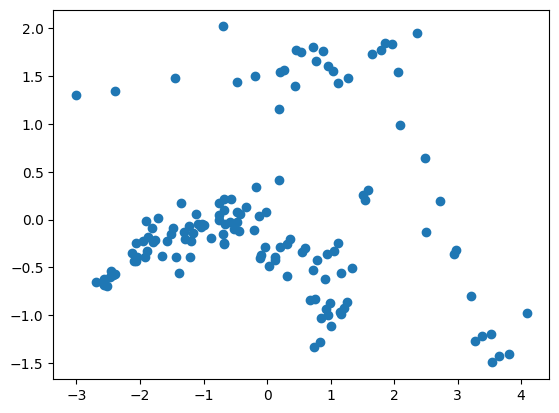

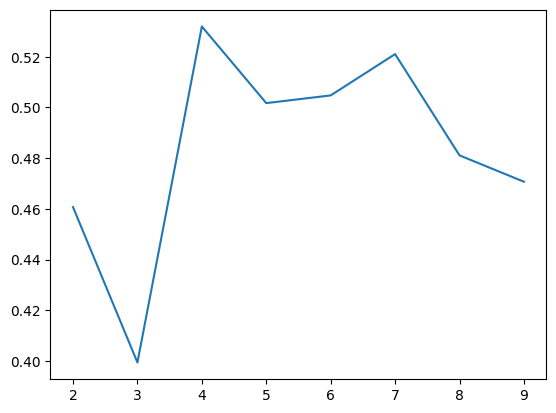

In [140]:
df2_train = df2[:-12]
from datetime import datetime
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scaler_k = StandardScaler()
subset = df2_train[['Federal Funds Rate', 'Housing Starts', 'Unemployment Rate', 'Cpi']] #FRED data
X = np.array(subset)
X = scaler_k.fit_transform(X)
#tsne_model = TSNE(n_components=2, random_state=42) #TSNE not used
#tsne_result = tsne_model.fit_transform(X)
pca_model = PCA(n_components=2, random_state=42) #dimensionality reduction
pca_result = pca_model.fit_transform(X)

df = pd.DataFrame(data=pca_result, columns=['c1', 'c2'])
plt.scatter(df['c1'], df['c2']) #visualize the clustering
plt.show()

#finding the right amount of clusters
sill_vals = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(df)
    #tsne_df['cluster'] = kmeans.labels_
    #asset['cluster'] = np.array(tsne_df['cluster'])
    sill_vals.append(silhouette_score(df, kmeans.labels_))
plt.plot(np.arange(2,10), sill_vals)
plt.show()

We use the clusters value of 4. It is optimal for this particular project as with the sparsity of the data choosing 7 would not do well. The silhouette scores between 4 and 7 is minimal as well. 

In [141]:
#create the K-means model
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit_predict(df)
df['cluster'] = kmeans_model.labels_
df2_train['cluster'] = np.array(df['cluster']) #identify regime within FRED data

#df2_train['cluster'] = df2_train['cluster'] 

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/3329687116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_train['cluster'] = np.array(df['cluster']) #identify regime within FRED data


### Cross reference the established regimes with the redfin data

In [142]:
#df_final['pred_average'] = (df_final['pred_LR'] + df_final['pred_Lasso']+ df_final['pred_Ridge'] + df_final['pred_Bayes'])/4
df_final = df_train[['Month of Period End','Median Sale Price', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'mse_LR', 'mse_Lasso', 'mse_Ridge', 'mse_En', 'mse_Average']]
df_final['cluster'] = df2_train['cluster'] #add the regime to the redfin data predictions
df_final = df_final[lookback:] 
df_final = df_final.reset_index(drop=True)

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/417663404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster'] = df2_train['cluster'] #add the regime to the redfin data predictions


### Plot the predictions of each model along with the identified regimes (1/12 to 7/23)

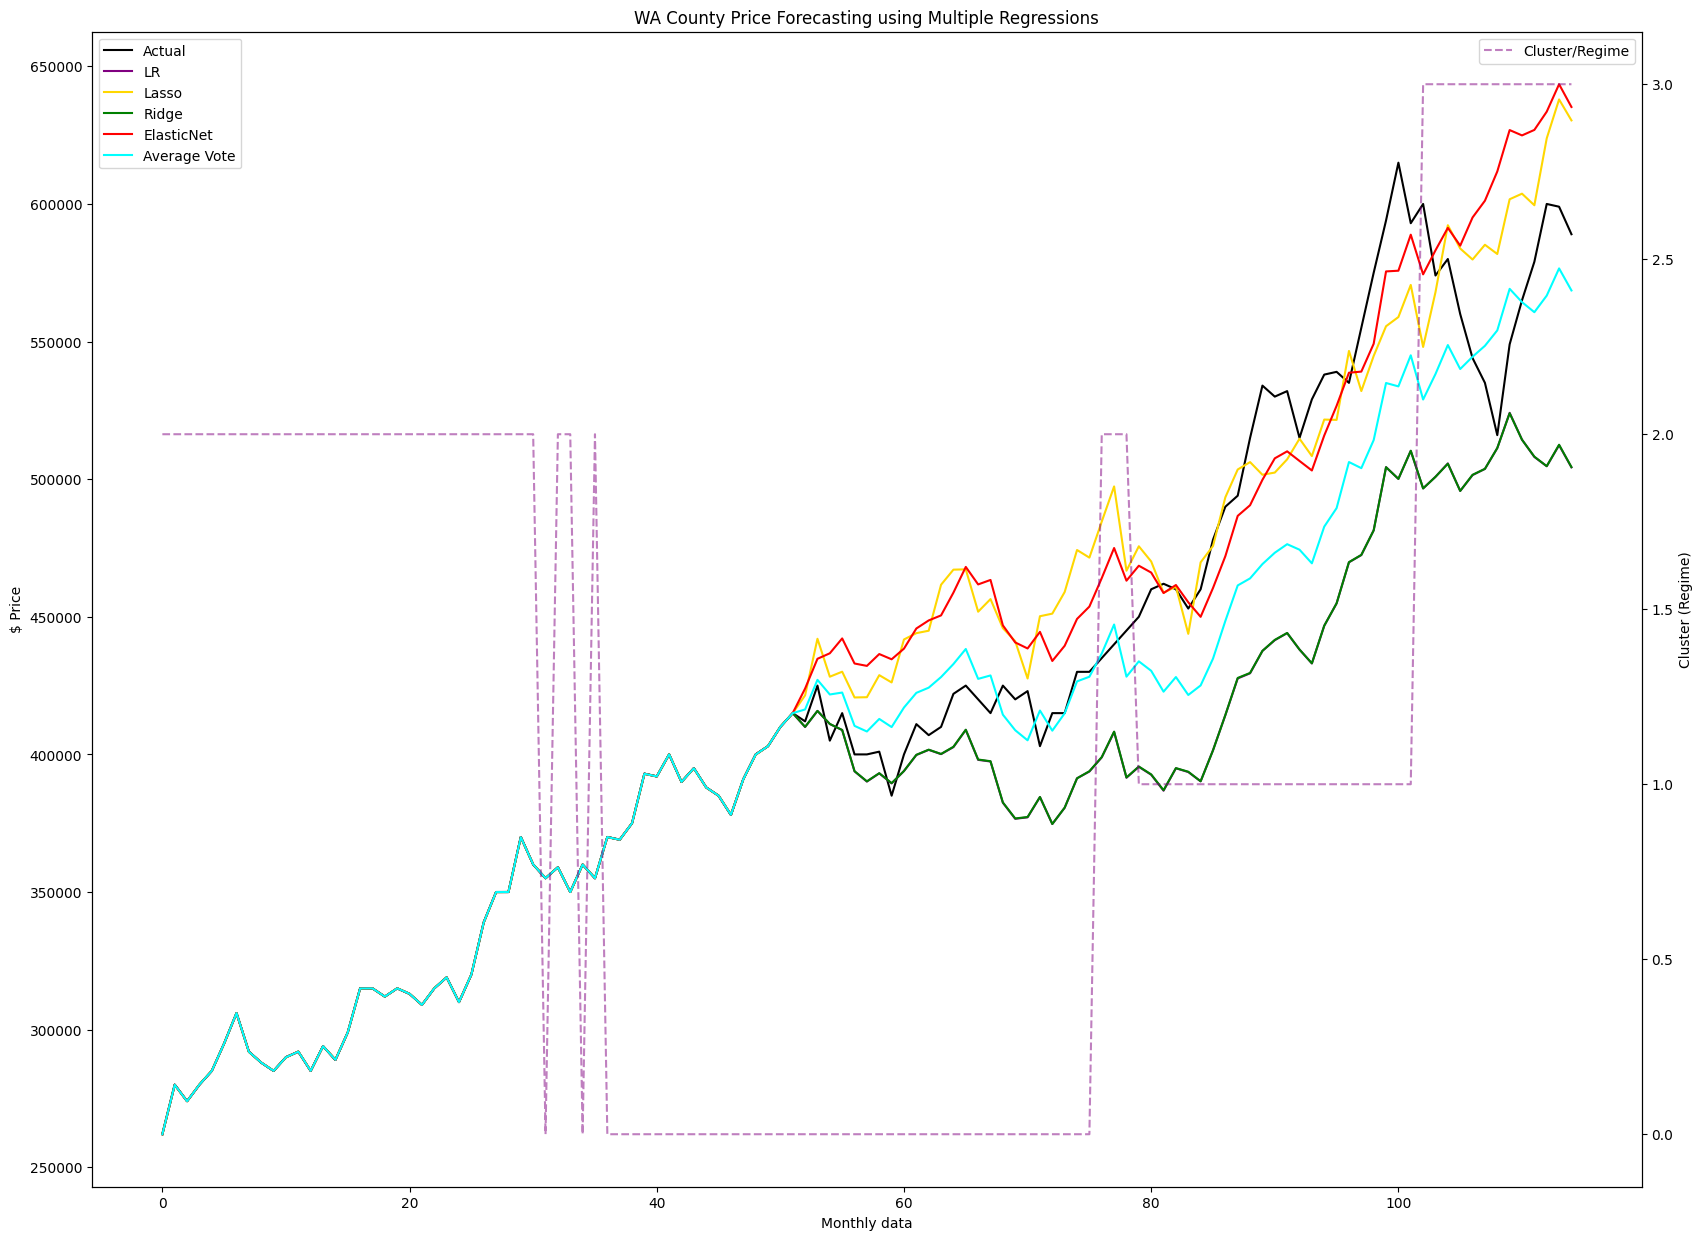

In [143]:
# Create figure and first axis for the price forecasting
fig, ax1 = plt.subplots(figsize=(20, 15))

# Plot the price forecasting on the primary y-axis
ax1.plot(df_final['Median Sale Price'], label='Actual', color='black')
ax1.plot(df_final['pred_LR'], label='LR', color='purple')
ax1.plot(df_final['pred_Lasso'], label='Lasso', color='gold')
ax1.plot(df_final['pred_Ridge'], label='Ridge', color='green')
ax1.plot(df_final['pred_En'], label='ElasticNet', color='red')
ax1.plot(df_final['pred_Average'], label='Average Vote', color='aqua')
ax1.set_xlabel('Monthly data')
ax1.set_ylabel('$ Price')
ax1.set_title('WA County Price Forecasting using Multiple Regressions')

# Create the second axis for the cluster (regime) information
ax2 = ax1.twinx()
ax2.plot(df_final['cluster'], label='Cluster/Regime', color='purple', linestyle='--', alpha=0.5)
ax2.set_ylabel('Cluster (Regime)')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the figure
plt.savefig('models_1.jpg')
plt.show()


### Evaluate model performances within regimes

In [144]:
performance = df_final[52:] #training and onwards we care about (performance in training period of each model which is the same is not usefull as it is almost always overfitted)
performance = performance.reset_index(drop=True)
performance = performance[['mse_LR', 'mse_Lasso', 'mse_Ridge','mse_En', 'mse_Average', 'cluster']]
performance_count = performance.groupby('cluster').count()
performance_count.to_csv('performance_count_regime.csv')
performance_count

,mse_LR,mse_Lasso,mse_Ridge,mse_En,mse_Average
cluster,,,,,
0,24,24,24,24,24
1,23,23,23,23,23
2,3,3,3,3,3
3,13,13,13,13,13


In [145]:
#MSE evaluation of each model within established regimes
scaler_2 = 10000000
assign = performance[['mse_LR', 'mse_Lasso', 'mse_Ridge','mse_En', 'cluster']]
assign = assign.groupby('cluster').mean()/scaler_2 #scaled for relevant visuals
assign.to_csv('cluster_analysis.csv')
assign 

,mse_LR,mse_Lasso,mse_Ridge,mse_En
cluster,,,,
0,57.699188,116.760533,57.436919,108.089565
1,662.543982,48.950392,661.731456,35.433491
2,172.568997,207.414940,171.607326,79.905479
3,465.076188,154.482476,464.759136,267.971678


### Creating a weight matrix for each model in each regime

In [146]:
#calculate dynamic weights for each model
def calc_weights(data, regime):
    weights_matrix = np.zeros((len(regime), 4))
    for i in regime:
        total_sum = float((1/data['mse_LR'][i] + 1/data['mse_Lasso'][i]+ 1/data['mse_Ridge'][i] +1/data['mse_En'][i]))
        weights_matrix[i, 0] = (1/data['mse_LR'][i])/total_sum
        weights_matrix[i, 1] = (1/data['mse_Lasso'][i])/total_sum
        weights_matrix[i, 2] = (1/data['mse_Ridge'][i])/total_sum
        weights_matrix[i, 3] = (1/data['mse_En'][i])/total_sum

    return weights_matrix

regime = [0,1,2,3]
weights_matrix = calc_weights(assign, regime)
print('weights:')
print(weights_matrix)

weights:
[[0.32975634 0.16295466 0.33126208 0.17602692]
 [0.02921032 0.3953619  0.02924618 0.54618159]
 [0.20010938 0.16649078 0.20123078 0.43216906]
 [0.14821912 0.44622009 0.14832023 0.25724056]]


In [147]:
# Define the regime numbers and model names
regimes = [0, 1, 2, 3]  # Just numbers now
models = ['LR', 'Lasso', 'Ridge', 'En']

# Create the DataFrame
df_weights = pd.DataFrame(weights_matrix, index=regimes, columns=models)

# Rename the index to "Regime"
df_weights.index.name = 'Regime'

# Display the DataFrame
df_weights.to_csv('df_weights.csv')
print(df_weights)

              LR     Lasso     Ridge        En
Regime                                        
0       0.329756  0.162955  0.331262  0.176027
1       0.029210  0.395362  0.029246  0.546182
2       0.200109  0.166491  0.201231  0.432169
3       0.148219  0.446220  0.148320  0.257241


### Setting up for the final testing period (8/23 to 7/24)
#### Finding regimes in this period

In [148]:
df1_test = df1[-12:]
df2_test = df2[-12:]

#scaler_k = StandardScaler()
subset = df2_test[['Federal Funds Rate', 'Housing Starts', 'Unemployment Rate', 'Cpi']]
X = np.array(subset)
X = scaler_k.transform(X)

#pca_model = PCA(n_components=2, random_state=42)
pca_result_test = pca_model.transform(X) #using the originally established pca model which was used to identify regimes 
df_test = pd.DataFrame(data=pca_result_test, columns=['c1', 'c2'])

#kmeans_model = KMeans(n_clusters=4, random_state=42)
df_test['cluster'] = kmeans_model.predict(df_test)
df2_test['cluster'] = np.array(df_test['cluster'])

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/3828468866.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test['cluster'] = np.array(df_test['cluster'])


### Get the feature matrix required to run final data on trained models

In [149]:
def get_X_test(df1, X_lr):
    features = []
    for i in df1.keys():
        if i not in ['Region', 'Month of Period End']:
            features.append(i)
    #df1 = history[['open', 'high', 'low', 'close', 'volume']].reset_index(drop=True)
    df1 = df1[features].reset_index(drop=True)

    #function to split X
    def ts_split(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
        return X
    # Forecasting target t+n days ahead
    def ts_split_y_n(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps + target_steps - 1]
                    for idx in range(n_obs)])
        return y
    # Forecasting target t+1 ahead
    def ts_split_y_1(ts, feature_steps, target_steps):
        n_obs = len(ts) - feature_steps - target_steps + 1
        y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                    for idx in range(n_obs)])
        return y

    value_features = lookback #we use last 24 months
    value_target = lookforward #to forecast 1 month median sale price
    #split the data into features with correct format

    df1_features_dict = {}  # Dictionary to hold the dynamically created variables
    for feature in features:
        feature_name = f"df1_{feature}"  # Dynamically create a variable name
        df1_features_dict[feature_name] = ts_split(np.array(df1[feature]), feature_steps=value_features, target_steps=value_target)

    #Target var of predicting price t+1 month ahead
    y_coin = ts_split_y_1(np.array(df1['Median Sale Price']), feature_steps = value_features, target_steps = value_target)

    #create the features matrix
    combined_array = np.stack(list(df1_features_dict.values()), axis=1)
    X_test = combined_array
    X_test = X_test[len(X_lr):]

    return X_test

### Use models to predict final testing period (8/23 to 7/24)

In [150]:
#feature matrix for running test period
X_test = get_X_test(df1, X_lr) #properly indexing 
#output the forecasted predictions for all models
#LR X
X_scaled = X_test.reshape(X_test.shape[0], -1)
X_scaled_lr = pd.DataFrame(X_scaled)
X_scaled_lr = scaler_lr.transform(X_scaled_lr) #same scaler used in original training of models **important**
pred_vals_lr = model_lr.predict(X_scaled_lr)
#Lasso X
X_scaled = X_test.reshape(X_test.shape[0], -1)
X_scaled_lasso = pd.DataFrame(X_scaled)
X_scaled_lasso = scaler_lasso.transform(X_scaled_lasso)
pred_vals_lasso = model_lasso.predict(X_scaled_lasso)
#Ridge X
X_scaled = X_test.reshape(X_test.shape[0], -1)
X_scaled_ridge = pd.DataFrame(X_scaled)
X_scaled_ridge = scaler_ridge.transform(X_scaled_ridge)
pred_vals_ridge = model_ridge.predict(X_scaled_ridge)
#ElasticNet X
X_scaled = X_test.reshape(X_test.shape[0], -1)
X_scaled_en = pd.DataFrame(X_scaled)
X_scaled_en = scaler_en.transform(X_scaled_en)
pred_vals_en = model_en.predict(X_scaled_en)

In [151]:
df1_test['pred_LR'] = np.NaN
df1_test['pred_Lasso'] = np.NaN
df1_test['pred_Ridge'] = np.NaN
df1_test['pred_En'] = np.NaN

#create dataframe with prediction results
df1_test['pred_LR'] = pred_vals_lr
df1_test['pred_Lasso'] = pred_vals_lasso
df1_test['pred_Ridge'] = pred_vals_ridge
df1_test['pred_En'] = pred_vals_en

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1985234564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test['pred_LR'] = np.NaN
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1985234564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test['pred_Lasso'] = np.NaN
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1985234564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

### We see prediction results for all models and identified regimes

In [152]:
df1_test_final = df1_test[['Median Sale Price', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En']]
df1_test_final['cluster'] = df2_test['cluster']
df1_test_final 

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/2252260137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test_final['cluster'] = df2_test['cluster']


,Median Sale Price,pred_LR,pred_Lasso,pred_Ridge,pred_En,cluster
139,587000,493185.333233,624762.653783,493260.391001,621682.123217,3
140,587000,485018.726055,601572.216695,485204.724511,607501.069185,3
141,550000,477477.432461,606406.049846,477600.126919,597226.679037,3
142,573000,470477.078128,603776.241758,470556.260194,587488.296570,3
143,574000,479042.290432,602581.126059,479123.757437,594216.731888,3
144,550000,472245.338913,606948.935423,472345.284114,586855.962061,3
145,570000,476101.469524,624754.886064,476181.673057,589213.196620,3
146,579000,482081.300377,648005.591597,482121.339783,600114.217399,3
147,580000,484278.012050,674031.173482,484286.832005,608450.244961,3
148,600000,473586.526589,679970.663949,473639.958728,608031.689233,3


We notice that the regime does not change during our testing period. 

### Creating the predictions from the dynamically weighted model

In [153]:
dot_product = df1_test_final[['pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En']]
df1_test_final['dynamic_vote'] = dot_product @ weights_matrix[df1_test_final['cluster'][-1:].values[0]] #associated weights for when regime = 3

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1106961509.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df1_test_final['dynamic_vote'] = dot_product @ weights_matrix[df1_test_final['cluster'][-1:].values[0]] #associated weights for when regime = 3
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1106961509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test_final['dynamic_vote'] = dot_product @ weights_matrix[df1_test_final['cluster'][-1:].value

In [154]:
df1_test_final['pred_Average'] = dot_product.mean(axis=1) #average model
df1_test_final['Month of Period End'] = df1['Month of Period End'][-12:] #extending the new results to the previous df
df1_test_final = df1_test_final[['Month of Period End', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'dynamic_vote', 'Median Sale Price', 'cluster']]
df1_test_final.to_csv('final_forecast.csv')
df1_test_final

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1657446275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test_final['pred_Average'] = dot_product.mean(axis=1) #average model
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/1657446275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_test_final['Month of Period End'] = df1['Month of Period End'][-12:] #extending the new results to the previous df


,Month of Period End,pred_LR,pred_Lasso,pred_Ridge,pred_En,pred_Average,dynamic_vote,Median Sale Price,cluster
139,8/23,493185.333233,624762.653783,493260.391001,621682.123217,558222.625309,584963.495113,587000,3
140,9/23,485018.726055,601572.216695,485204.724511,607501.069185,544824.184111,568562.248337,587000,3
141,10/23,477477.432461,606406.049846,477600.126919,597226.679037,539677.572066,565830.532325,550000,3
142,11/23,470477.078128,603776.241758,470556.260194,587488.296570,533074.469163,560069.617864,573000,3
143,12/23,479042.290432,602581.126059,479123.757437,594216.731888,538740.976454,563807.421127,574000,3
144,1/24,472245.338913,606948.935423,472345.284114,586855.962061,534598.880128,561850.113930,550000,3
145,2/24,476101.469524,624754.886064,476181.673057,589213.196620,541562.806316,571542.429498,570000,3
146,3/24,482081.300377,648005.591597,482121.339783,600114.217399,553080.612289,586488.844035,579000,3
147,4/24,484278.012050,674031.173482,484286.832005,608450.244961,562761.565624,600893.126804,580000,3
148,5/24,473586.526589,679970.663949,473639.958728,608031.689233,558807.209625,600271.947926,600000,3


### Plotting the testing period results (8/23 to 7/24)

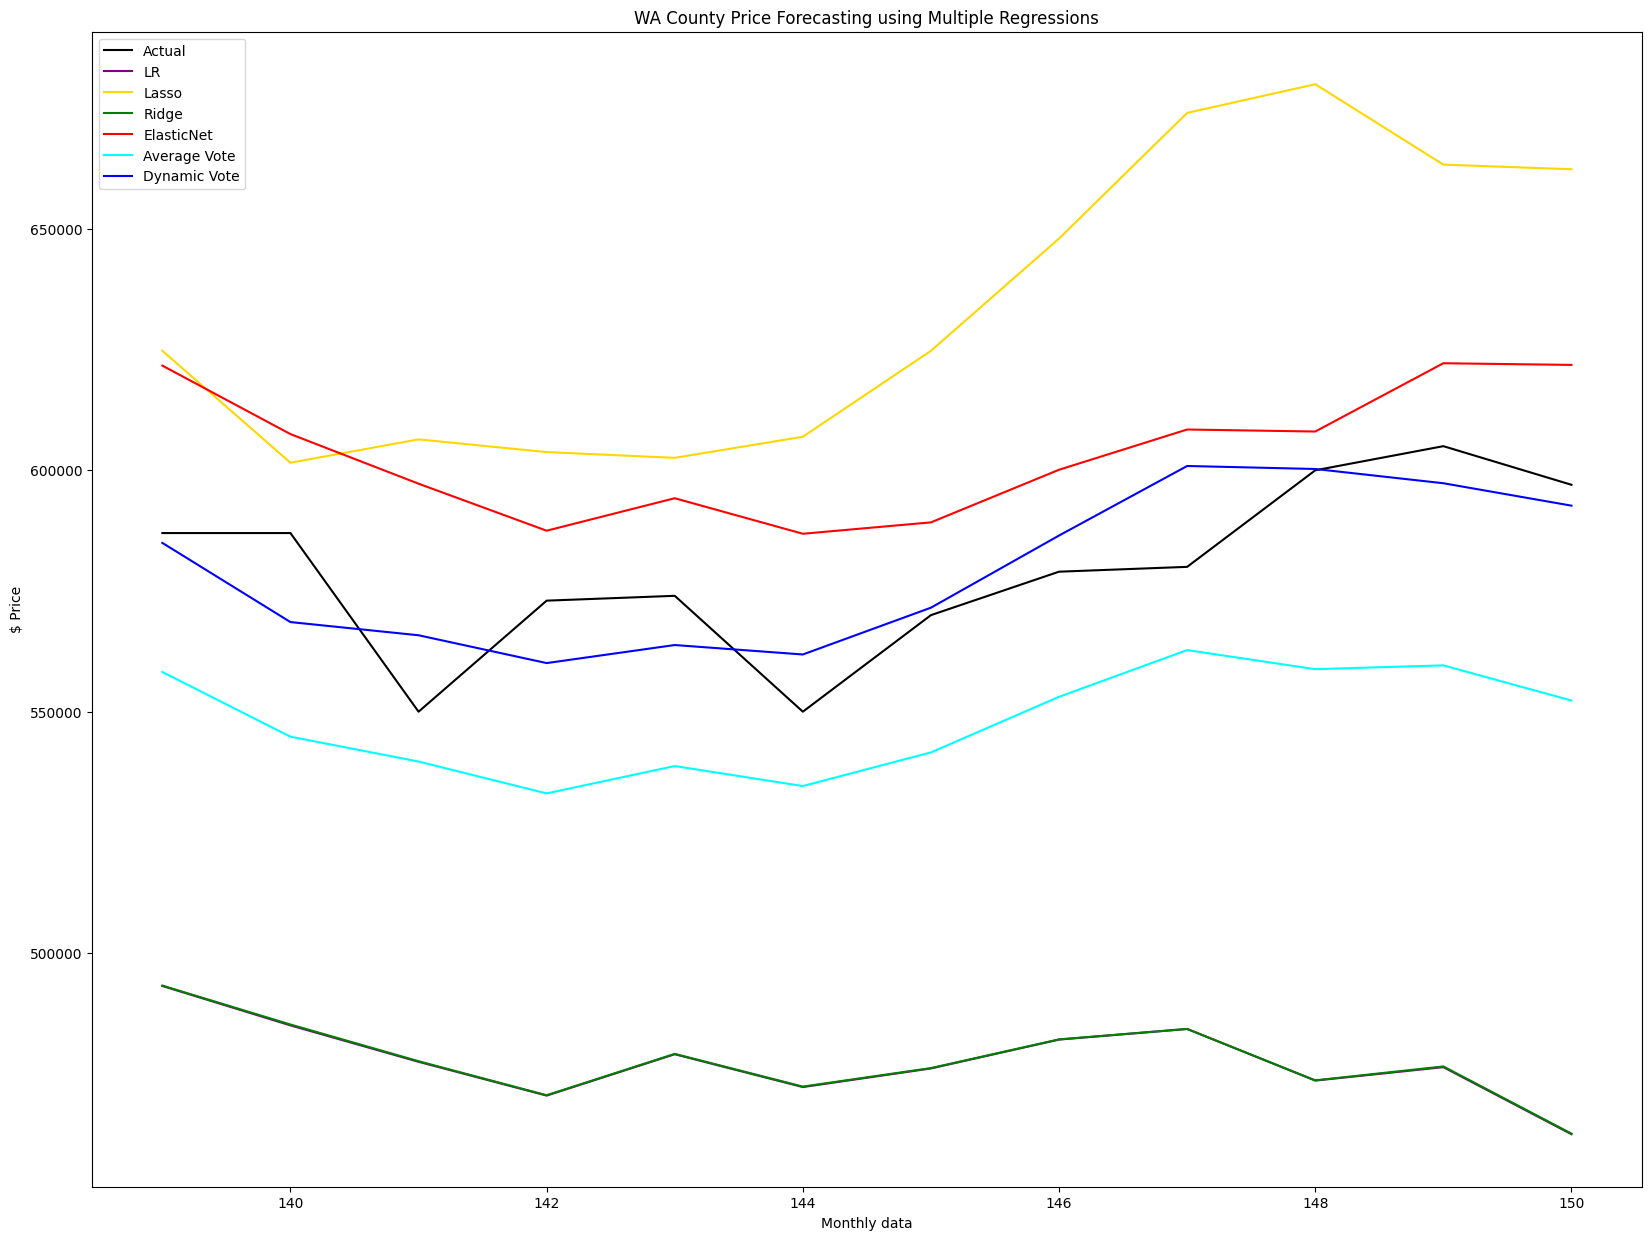

In [155]:
plt.figure(figsize=(20,15))
plt.plot(df1_test_final['Median Sale Price'], label='Actual', color='black')
plt.plot(df1_test_final['pred_LR'], label='LR', color='purple')
plt.plot(df1_test_final['pred_Lasso'], label='Lasso', color='gold')
plt.plot(df1_test_final['pred_Ridge'], label='Ridge', color='green')
plt.plot(df1_test_final['pred_En'], label='ElasticNet', color='red')
plt.plot(df1_test_final['pred_Average'], label='Average Vote', color='aqua')
plt.plot(df1_test_final['dynamic_vote'], label='Dynamic Vote', color='blue')
plt.title('WA County Price Forecasting using Multiple Regressions')
plt.ylabel('$ Price')
plt.xlabel('Monthly data')
plt.legend()
plt.savefig('closer_look.jpg')
plt.show()

### Final results

In [156]:
df_meow = df1_test_final[['Median Sale Price', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'dynamic_vote', 'cluster']]
df_meow 

,Median Sale Price,pred_LR,pred_Lasso,pred_Ridge,pred_En,pred_Average,dynamic_vote,cluster
139,587000,493185.333233,624762.653783,493260.391001,621682.123217,558222.625309,584963.495113,3
140,587000,485018.726055,601572.216695,485204.724511,607501.069185,544824.184111,568562.248337,3
141,550000,477477.432461,606406.049846,477600.126919,597226.679037,539677.572066,565830.532325,3
142,573000,470477.078128,603776.241758,470556.260194,587488.296570,533074.469163,560069.617864,3
143,574000,479042.290432,602581.126059,479123.757437,594216.731888,538740.976454,563807.421127,3
144,550000,472245.338913,606948.935423,472345.284114,586855.962061,534598.880128,561850.113930,3
145,570000,476101.469524,624754.886064,476181.673057,589213.196620,541562.806316,571542.429498,3
146,579000,482081.300377,648005.591597,482121.339783,600114.217399,553080.612289,586488.844035,3
147,580000,484278.012050,674031.173482,484286.832005,608450.244961,562761.565624,600893.126804,3
148,600000,473586.526589,679970.663949,473639.958728,608031.689233,558807.209625,600271.947926,3


### Plotting the final results with regimes full data (1/12 to 7/24)

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_98017/2012032888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['dynamic_vote'] = np.NaN


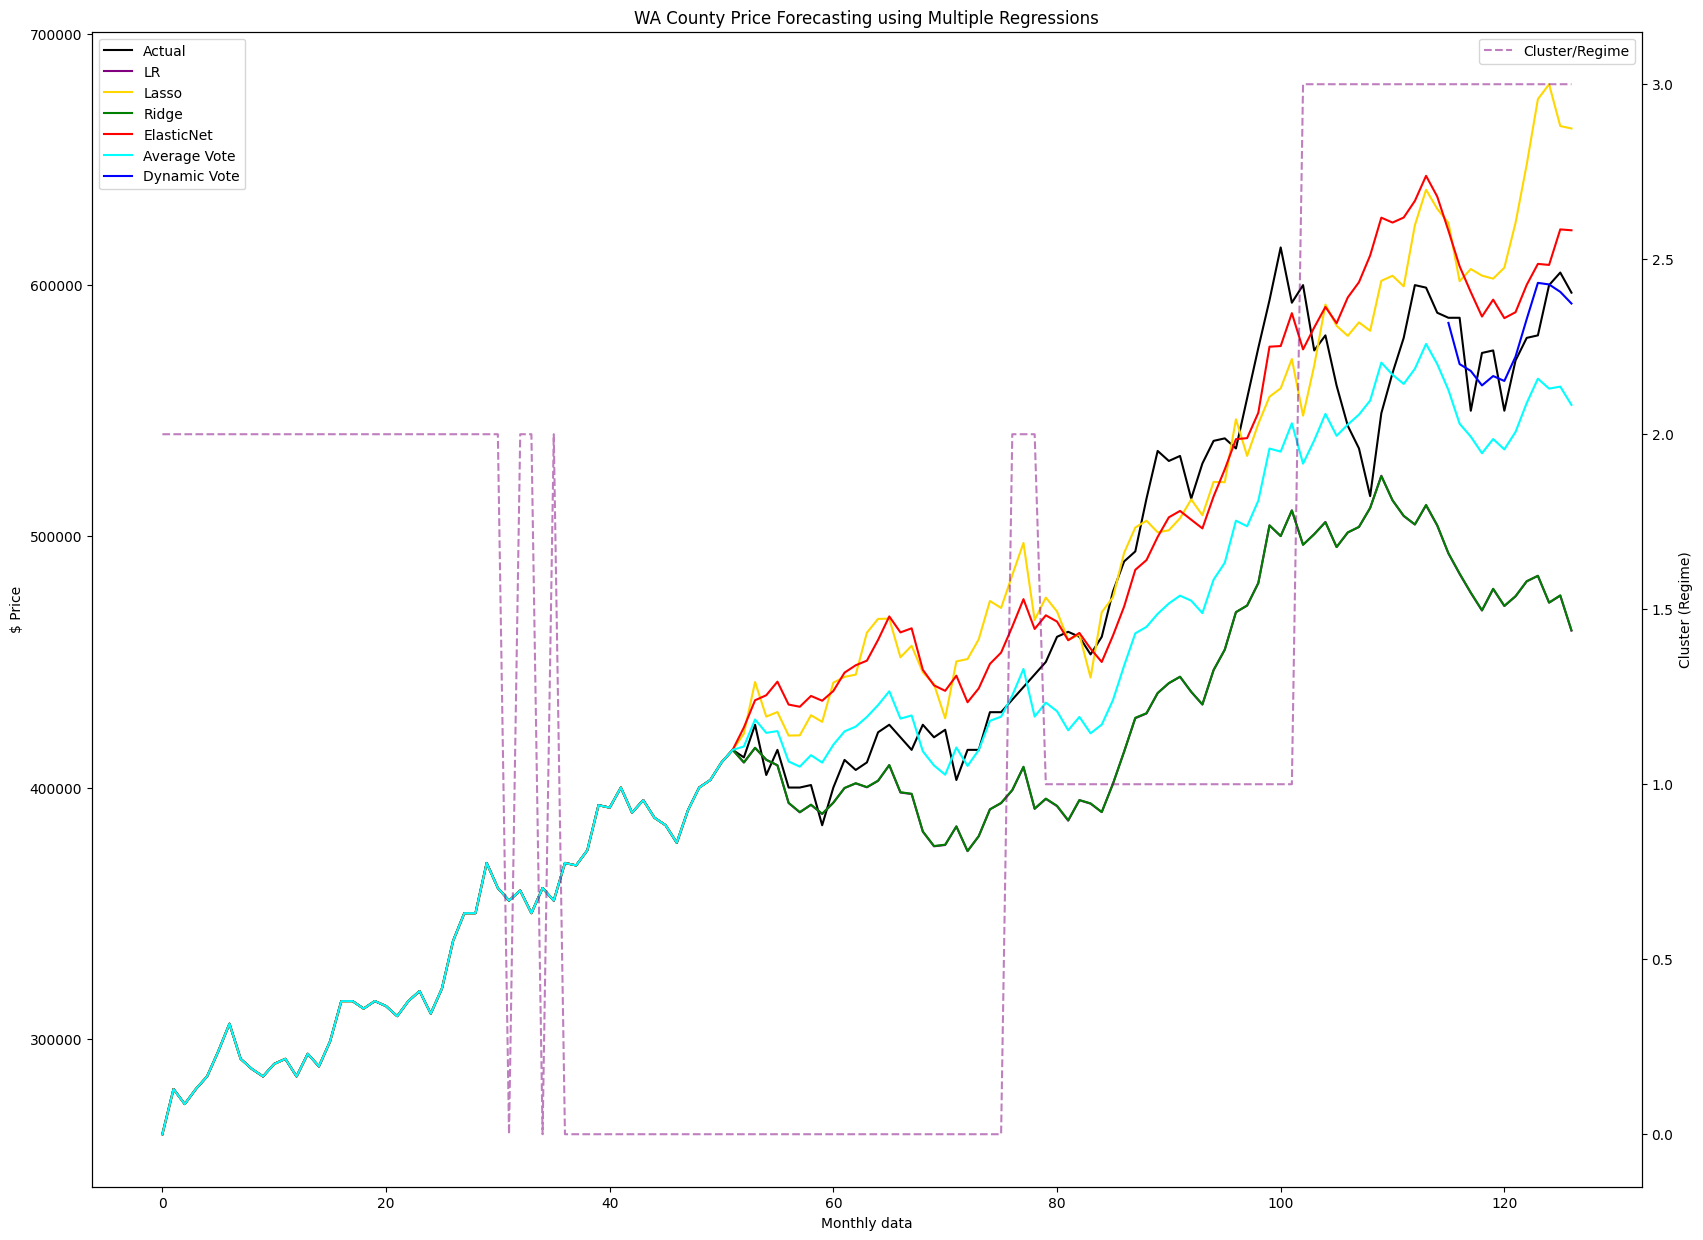

In [157]:
df_all = df_final[['Median Sale Price', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'cluster']]
df_all['dynamic_vote'] = np.NaN

df_last = df1_test_final[['Median Sale Price', 'pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'dynamic_vote', 'cluster']]
df_combined = pd.concat([df_all, df_last], axis=0, ignore_index=True)
df_combined
# Create figure and first axis for the price forecasting
fig, ax1 = plt.subplots(figsize=(20, 15))

# Plot the price forecasting on the primary y-axis
ax1.plot(df_combined['Median Sale Price'], label='Actual', color='black')
ax1.plot(df_combined['pred_LR'], label='LR', color='purple')
ax1.plot(df_combined['pred_Lasso'], label='Lasso', color='gold')
ax1.plot(df_combined['pred_Ridge'], label='Ridge', color='green')
ax1.plot(df_combined['pred_En'], label='ElasticNet', color='red')
ax1.plot(df_combined['pred_Average'], label='Average Vote', color='aqua')
ax1.plot(df_combined['dynamic_vote'], label='Dynamic Vote', color='blue')
ax1.set_xlabel('Monthly data')
ax1.set_ylabel('$ Price')
ax1.set_title('WA County Price Forecasting using Multiple Regressions')

# Create the second axis for the cluster (regime) information
ax2 = ax1.twinx()
ax2.plot(df_combined['cluster'], label='Cluster/Regime', color='purple', linestyle='--', alpha=0.5)
ax2.set_ylabel('Cluster (Regime)')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the figure
plt.savefig('models_final.jpg')
plt.show()


In [158]:
df1_test_final = df1_test_final[['pred_LR', 'pred_Lasso', 'pred_Ridge', 'pred_En', 'pred_Average', 'dynamic_vote', 'Median Sale Price','cluster']]
df1_test_final

,pred_LR,pred_Lasso,pred_Ridge,pred_En,pred_Average,dynamic_vote,Median Sale Price,cluster
139,493185.333233,624762.653783,493260.391001,621682.123217,558222.625309,584963.495113,587000,3
140,485018.726055,601572.216695,485204.724511,607501.069185,544824.184111,568562.248337,587000,3
141,477477.432461,606406.049846,477600.126919,597226.679037,539677.572066,565830.532325,550000,3
142,470477.078128,603776.241758,470556.260194,587488.296570,533074.469163,560069.617864,573000,3
143,479042.290432,602581.126059,479123.757437,594216.731888,538740.976454,563807.421127,574000,3
144,472245.338913,606948.935423,472345.284114,586855.962061,534598.880128,561850.113930,550000,3
145,476101.469524,624754.886064,476181.673057,589213.196620,541562.806316,571542.429498,570000,3
146,482081.300377,648005.591597,482121.339783,600114.217399,553080.612289,586488.844035,579000,3
147,484278.012050,674031.173482,484286.832005,608450.244961,562761.565624,600893.126804,580000,3
148,473586.526589,679970.663949,473639.958728,608031.689233,558807.209625,600271.947926,600000,3


In [159]:
df1_test_final['mse_LR'] = (df1_test_final['Median Sale Price'] - df1_test_final['pred_LR'])**2
df1_test_final['mse_Lasso'] = (df1_test_final['Median Sale Price']- df1_test_final['pred_Lasso'])**2
df1_test_final['mse_Ridge'] = (df1_test_final['Median Sale Price'] - df1_test_final['pred_Ridge'])**2
df1_test_final['mse_En']= (df1_test_final['Median Sale Price'] - df1_test_final['pred_En'])**2
df1_test_final['mse_Average'] = (df1_test_final['Median Sale Price'] - df1_test_final['pred_Average'])**2
df1_test_final['mse_Dynamic'] = (df1_test_final['Median Sale Price'] - df1_test_final['dynamic_vote'])**2

# Create a dictionary with your data
data = {
    'Model': ['LR', 'Lasso', 'Ridge', 'En', 'Average', 'Dynamic'],
    'MSE': [df1_test_final['mse_LR'].mean()/scaler_value, df1_test_final['mse_Lasso'].mean()/scaler_value, df1_test_final['mse_Ridge'].mean()/scaler_value
            ,df1_test_final['mse_En'].mean()/scaler_value, df1_test_final['mse_Average'].mean()/scaler_value
            ,df1_test_final['mse_Dynamic'].mean()/scaler_value]}

# Convert to DataFrame
df_mse_final = pd.DataFrame(data)

# Display the DataFrame
print(df_mse_final)
df_mse_final.to_csv('df_mse_final.csv')

     Model           MSE
0       LR  10669.119026
1    Lasso   3374.741259
2    Ridge  10650.111744
3       En    702.579553
4  Average   1110.030327
5  Dynamic    131.576863


### Correlation plots and VIF

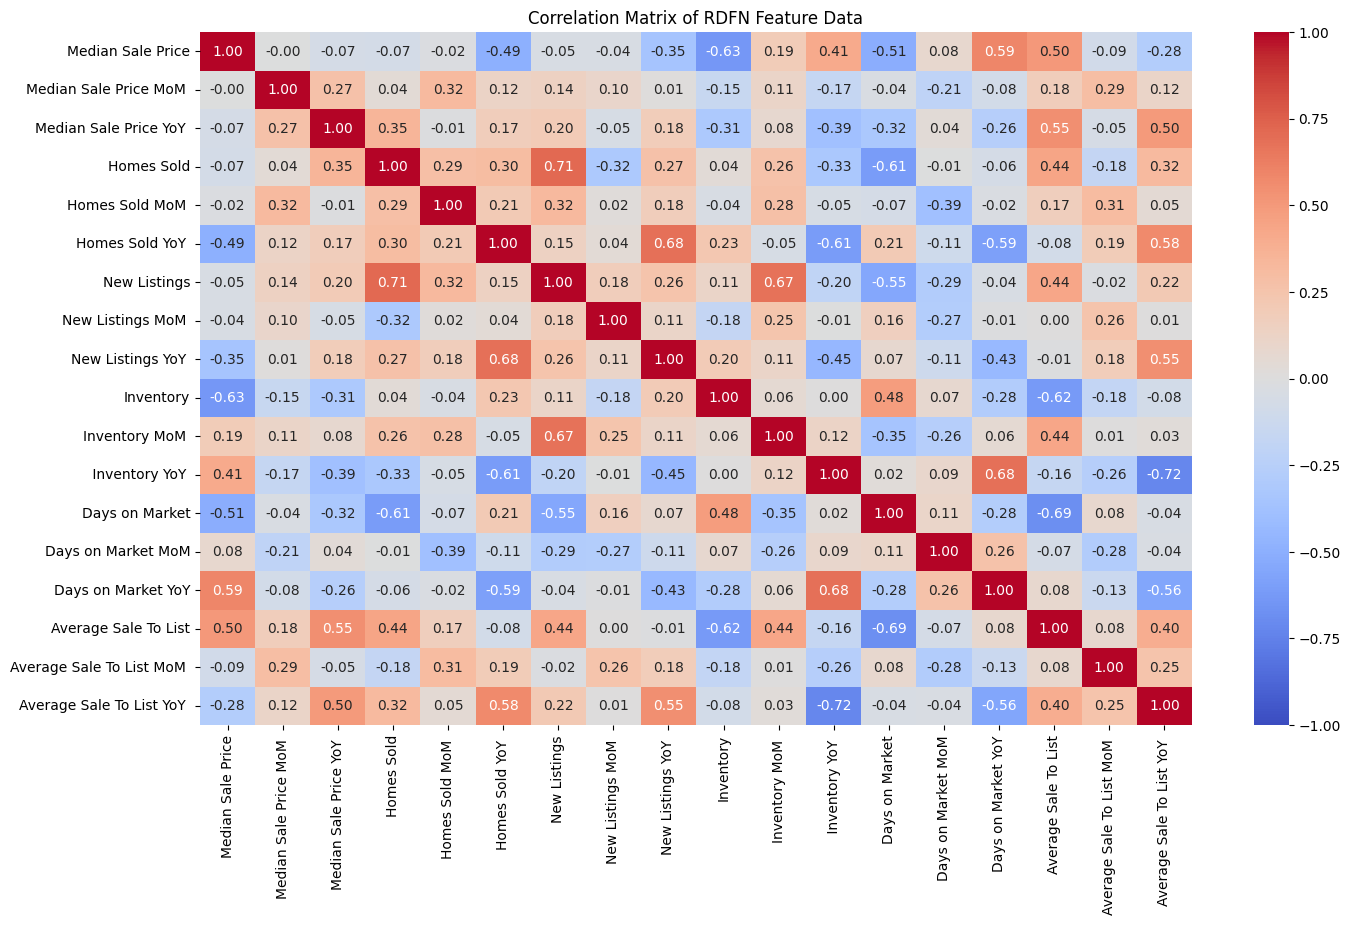

In [160]:
import seaborn as sns

corr = df1.iloc[:,2:]
corr_matrix = corr.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of RDFN Feature Data")
plt.savefig('corr_matrix.jpg')
plt.show()

In [161]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume X is your feature matrix
vif_data = pd.DataFrame()
X = corr
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                      feature         VIF
0           Median Sale Price   59.589733
1      Median Sale Price MoM     1.543747
2      Median Sale Price YoY     6.232165
3                  Homes Sold  140.101801
4             Homes Sold MoM     2.109217
5             Homes Sold YoY     3.469069
6                New Listings  106.913781
7           New Listings MoM     3.096238
8           New Listings YoY     2.306550
9                   Inventory   45.800409
10             Inventory MoM     2.962864
11             Inventory YoY     3.915472
12             Days on Market   19.105016
13         Days on Market MoM    1.903673
14         Days on Market YoY    4.174374
15       Average Sale To List  329.501867
16  Average Sale To List MoM     1.896161
17  Average Sale To List YoY     3.476026
